In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc


import data_utils
import modeling

%load_ext autoreload
%autoreload 2

SEED = 42
model_to_auc = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hparam Tuning

In [594]:
DROP_COLS = []
# Load data
X, y = data_utils.load_dataset(
    include_demo=True,
    include_wsi=True,
    include_omics=True,
    omics_n_feats=5,
    wsi_n_feats=5,
)
X.drop(columns=DROP_COLS, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y['event'])
print(X_train.shape, X_test.shape)

(367, 21) (92, 21)


In [595]:
hparams = dict(
    learning_rate=1,
    n_estimators=200,
    subsample=0.8,
    min_samples_leaf=4,
    max_features=0.3,
    max_depth=3,
    # validation_fraction=0.2,
    # n_iter_no_change=5,
    dropout_rate=0.2,
    random_state=SEED
)
model = GradientBoostingSurvivalAnalysis(**hparams).fit(X_train, y_train)

In [596]:
c, b, a = modeling.get_test_scores(model, X_train, y_train, y)
print('TRAIN SCORES')
print(f"Concordance index: {c:.3f}")
print(f"IBS: {b:.3f}")
print(f"Mean AUC: {a[-1]:.3f}")
print()
c, b, a = modeling.get_test_scores(model, X_test, y_test, y)
print('TEST SCORES')
print(f"Concordance index: {c:.3f}")
print(f"IBS: {b:.3f}")
print(f"Mean AUC: {a[-1]:.3f}")

TRAIN SCORES
Concordance index: 0.865
IBS: 0.124
Mean AUC: 0.897

TEST SCORES
Concordance index: 0.646
IBS: 0.166
Mean AUC: 0.651


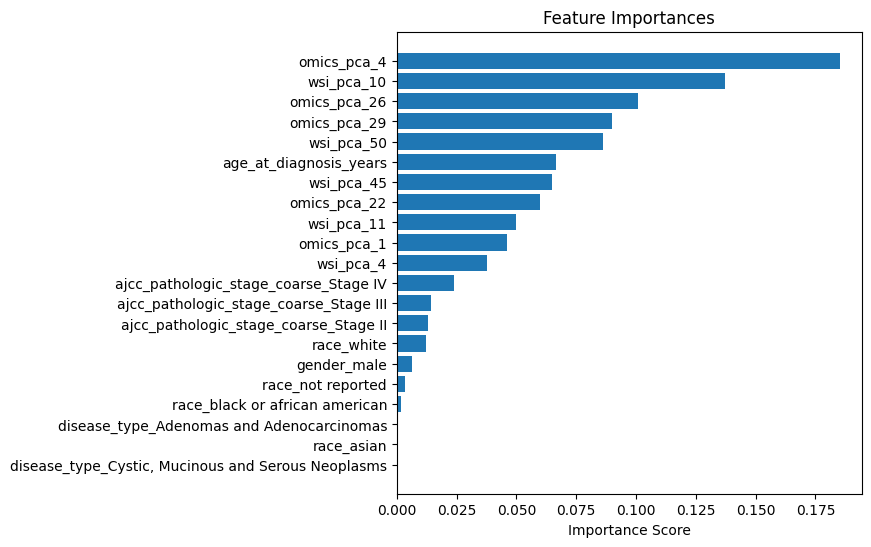

In [597]:
# Feature importances
importances = np.abs(model.feature_importances_)
indices = np.argsort(importances)

plt.figure(figsize=(6, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Feature Importances')
plt.show()

## Eval

In [598]:
model = GradientBoostingSurvivalAnalysis(**hparams)
cv = modeling.CustomStratifiedKFold(n_splits=5)

In [599]:
def scoring_fn(model, X_, y_):
    c, b, a = modeling.get_test_scores(model, X_, y_, y)
    return {'c-index': c, 'ibs': b, 'auc': a[-1]}

In [600]:
out = cross_validate(model, X, y, scoring=scoring_fn, cv=cv)

In [601]:
c, b, a = out['test_c-index'], out['test_ibs'], out['test_auc']
print(f'CV C-index: {c.mean():.3f} ± {c.std():.3f}')
print(f'CV IBS: {b.mean():.3f} ± {b.std():.3f}')
print(f'CV mAUC: {a.mean():.3f} ± {a.std():.3f}')

CV C-index: 0.668 ± 0.062
CV IBS: 0.161 ± 0.010
CV mAUC: 0.681 ± 0.069


### Dynamic ROC AUC

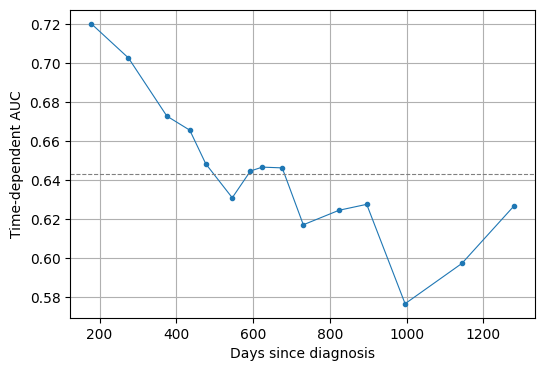

In [584]:
times = np.percentile(y['survival_time'], np.linspace(10, 81, 15))
risk_scores = cross_val_predict(model, X, y, cv=cv)
aucs = cumulative_dynamic_auc(y, y, risk_scores, times)
plt.figure(figsize=(6, 4))
plt.plot(times, aucs[0], marker="o", markersize=3, linewidth=0.8, color='C0')
plt.axhline(aucs[-1], linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Days since diagnosis")
plt.ylabel("Time-dependent AUC")
plt.grid(True)

In [585]:
model_to_auc['WSI+Omics'] = aucs[0]

In [586]:
list(model_to_auc.keys())

['Demo_only',
 'WSI_only',
 'Demo+WSI',
 'Demo+Omics',
 'Omics_only',
 'All',
 'WSI+Omics']

### Failure Cases

In [602]:
cases = pd.read_csv('data/case_data_filtered.csv')
file_sizes = pd.read_csv('data/wsi_sizes.csv')
cases = cases.merge(file_sizes, on='case_id', how='left')
cases.set_index('case_id', inplace=True)

In [603]:
def find_discordances(risk_scores, y):
    """ For each sample, count how often its risk score violates the expected ordering with other
    samples.
    """
    n_samples = len(risk_scores)
    discordances = np.zeros(n_samples)
    comparisons = np.zeros(n_samples)

    for i in range(n_samples):
        for j in range(n_samples):
            if i == j:
                continue
            # Only compare if we can determine correct ordering
            # (one died before other's last follow-up)
            if y[i]['event'] and (y[i]['survival_time'] < y[j]['survival_time']):
                # i died before j's last follow-up i should have higher risk score
                comparisons[i] += 1
                comparisons[j] += 1
                if risk_scores[i] < risk_scores[j]:
                    discordances[i] += 1
                    discordances[j] += 1

    comparisons[comparisons == 0] = np.nan
    return discordances / comparisons, comparisons

In [604]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED + 1, stratify=y['event'])

In [605]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [606]:
discordances, comparisons = find_discordances(preds, y_test)
discordances = (discordances - discordances.mean()) / discordances.std()

In [607]:
df = cases.loc[X_test.index].copy().assign(discordance=discordances, comparisons=comparisons)
df = df[df.comparisons >= 8]

In [608]:
df.groupby(pd.qcut(df.age_at_diagnosis_years, 5))['discordance'].agg(['mean', 'count'])

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_71431/3215449720.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df.age_at_diagnosis_years, 5))['discordance'].agg(['mean', 'count'])


,mean,count
age_at_diagnosis_years,,
"(38.999, 56.0]",0.164398,26
"(56.0, 64.0]",-0.060774,29
"(64.0, 70.0]",-0.105197,26
"(70.0, 75.0]",0.256436,23
"(75.0, 87.0]",0.073759,22


In [609]:
df.groupby('race').discordance.agg(['mean', 'count'])

,mean,count
race,,
asian,-0.011161,3
black or african american,0.328370,18
not reported,-0.162218,13
white,0.017526,99


In [610]:
df.groupby(pd.qcut(df.survival_time, 5))['discordance'].mean()

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_71431/1791331223.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df.survival_time, 5))['discordance'].mean()


survival_time
(3.999, 448.0]      0.072700
(448.0, 625.6]     -0.188987
(625.6, 834.4]      0.010139
(834.4, 1266.8]     0.152251
(1266.8, 6732.0]    0.146676
Name: discordance, dtype: float64

In [611]:
df.groupby('gender').discordance.agg(['mean', 'count'])

,mean,count
gender,,
female,0.186038,72
male,-0.129365,61


In [612]:
df.groupby('ajcc_pathologic_stage_coarse').discordance.agg(['count', 'mean'])

,count,mean
ajcc_pathologic_stage_coarse,,
Stage I,78,-0.042565
Stage II,24,0.008501
Stage III,21,0.336997
Stage IV,9,0.260749


In [613]:
df.groupby('disease_type').discordance.agg(['count', 'mean'])

,count,mean
disease_type,,
Acinar Cell Neoplasms,6,-0.129320
Adenomas and Adenocarcinomas,122,0.054712
"Cystic, Mucinous and Serous Neoplasms",5,-0.079104


In [614]:
df.groupby(pd.qcut(df.file_size, 5)).discordance.agg(['count', 'mean'])

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_71431/3803734945.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df.file_size, 5)).discordance.agg(['count', 'mean'])


,count,mean
file_size,,
"(0.014100000000000001, 0.227]",27,-0.068554
"(0.227, 0.461]",26,0.309310
"(0.461, 0.758]",27,-0.175944
"(0.758, 1.271]",26,0.348778
"(1.271, 4.086]",27,-0.185385


In [615]:
X.columns

Index(['age_at_diagnosis_years', 'disease_type_Adenomas and Adenocarcinomas',
       'disease_type_Cystic, Mucinous and Serous Neoplasms', 'gender_male',
       'race_asian', 'race_black or african american', 'race_not reported',
       'race_white', 'ajcc_pathologic_stage_coarse_Stage II',
       'ajcc_pathologic_stage_coarse_Stage III',
       'ajcc_pathologic_stage_coarse_Stage IV', 'wsi_pca_4', 'wsi_pca_10',
       'wsi_pca_11', 'wsi_pca_45', 'wsi_pca_50', 'omics_pca_1', 'omics_pca_4',
       'omics_pca_22', 'omics_pca_26', 'omics_pca_29'],
      dtype='object')

### Cross-model ROC curves

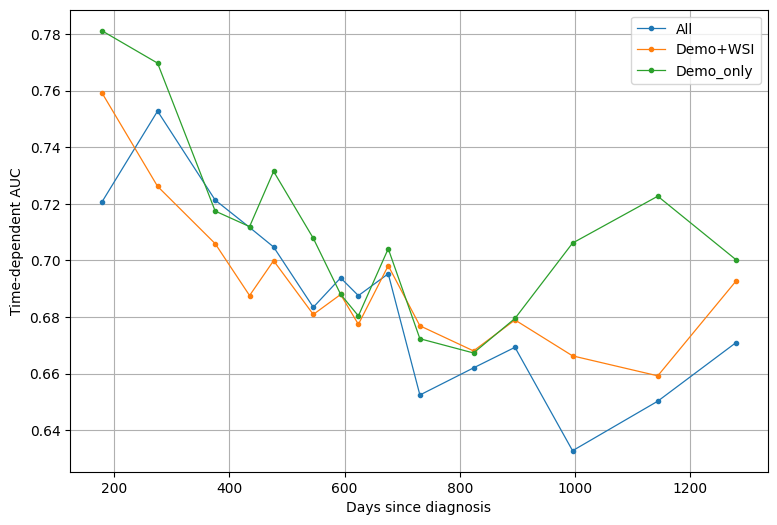

In [593]:
model_to_auc_ = {k: model_to_auc[k] for k in ['All', 'Demo+WSI', 'Demo_only']}
times = np.percentile(y['survival_time'], np.linspace(10, 81, 15))
plt.figure(figsize=(9, 6))
for i, (name, aucs) in enumerate(model_to_auc_.items()):
    plt.plot(times, aucs, marker="o", markersize=3, linewidth=0.9, color=f'C{i}', label=name)
    # plt.axhline(np.mean(aucs), linestyle="--", linewidth=0.8, color=f'C{i}')
plt.xlabel("Days since diagnosis")
plt.ylabel("Time-dependent AUC")
plt.legend()
plt.grid(True)

In [667]:
list(model_to_auc.keys())

['Demo_only', 'Omics_only', 'Demo+Omics', 'WSI+Omics', 'All', 'WSI_only']